In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

class Ship:
    def __init__(self, length, symbol, name):
        self.length = length
        self.symbol = symbol
        self.name = name

In [2]:
class GoodPlayer:
    def __init__(self, game, ship_types):
        self.game = game
        self.ship_types = ship_types
        self.ROWS, self.COLS = game.shape
        self.missed = []
        self.destroyed = []
        self.spot_prob = np.zeros((self.ROWS, self.COLS))
        self.state = 0 # Hunting
        self.moves = 0
        self.game_heat = np.array([[1 if ch != '.' else 0 for ch in row] for row in game])
        self.game_error = np.zeros((self.ROWS, self.COLS))
        
    def check_destroyed(self):
        for ship in self.ship_types:
            if not np.isin(ship.symbol, self.game):
                print(f'{ship.name} destroyed!')
                self.ship_types.remove(ship)
                return ship.length
        return 0
        
    def valid_position(self, row, col):
        if row < 0 or row >= self.ROWS or col < 0 or col >= self.COLS:
            return False
        if (row, col) in self.missed:
            return False
        return True
    
    def valid_place(self, row, col, length, direction):
        if not self.valid_position(row, col):
            return False
        if direction == 'v':
            for r in range(row, row + length):
                if not self.valid_position(r, col):
                    return False
            return True
        if direction == 'h':
            for c in range(col, col + length):
                if not self.valid_position(row, c):
                    return False
            return True
        
        return False
    
    def choose(self):
        if (self.state == 0):
            self.hunt_prob()
        if (self.state == 1):
            self.target_prob()
        
        max_ = 0
        point = (0, 0)
        self.plot()
        for i, value in np.ndenumerate(self.spot_prob):
            if value > max_ and i not in self.destroyed:
                point = i
                max_ = value
                
        return point
    
    def attack(self):
        if len(self.ship_types) == 0:
            self.hunt_prob()
            self.plot()
            print(f'Finished in {self.moves} moves!')
            return False
        self.moves += 1
        point = self.choose()
        print(point)
        # Miss
        if game[point] == '.':
            print('Missed!')
            self.missed.append(point)
            self.game[point] = 'o'
        # Hit
        else:
            print('Hit!')
            self.destroyed.append(point)
            self.game[point] = 'X'
            self.game_heat[point] = 0
            self.state = 1
        
        destroyed_length = self.check_destroyed()
        
        if destroyed_length:
            tp = self.destroyed[0]
            start = 0
            end = 0
            # Vertical
            if point[1] == tp[1]:
                # Point is topmost
                if point[0] < tp[0]:
                    start = point[0]
                    end = point[0] + destroyed_length
                else:
                    start = point[0] - destroyed_length + 1
                    end = point[0] + 1
                for r in range(start, end):
                    self.missed.append((r, tp[1]))
                    self.destroyed.remove((r, tp[1]))
            # Horizontal
            if point[0] == tp[0]:
                # Point is leftmost
                if point[1] < tp[1]:
                    start = point[1]
                    end = point[1] + destroyed_length
                else:
                    start = point[1] - destroyed_length + 1
                    end = point[1] + 1
                for c in range(start, end):
                    self.missed.append((tp[0], c))
                    self.destroyed.remove((tp[0], c))
            
            print(len(self.destroyed))
            if len(self.destroyed) == 0:
                self.state = 0
                
        return True
    
    def hunt_prob(self):
        self.spot_prob = np.zeros((self.ROWS, self.COLS))
        for ship in self.ship_types:
            for row in range(self.ROWS):
                for col in range(self.COLS):
                    # check cross hair
                    for i in range(row - ship.length + 1, row + 1):
                        if self.valid_place(i, col, ship.length, 'v'):
                            self.spot_prob[row, col] += 1
                    for i in range(col - ship.length + 1, col + 1):
                        if self.valid_place(row, i, ship.length, 'h'):
                            self.spot_prob[row, col] += 1
        # Parity (remove all even-odd odd-even positions)
        smallest = np.inf
        for ship in self.ship_types:
            if ship.length < smallest:
                smallest = ship.length
        for pos, value in np.ndenumerate(self.spot_prob):
            if pos[0] % smallest != pos[1] % smallest:
                self.spot_prob[pos] = 0

    def target_prob(self):
        self.spot_prob = np.zeros((self.ROWS, self.COLS))
        tp = self.destroyed[0]
        row = tp[0]
        col = tp[1]
        
        for ship in self.ship_types:
            # For start position in crosshair
            for i in range(row - ship.length + 1, row + 1):
                if self.valid_place(i, col, ship.length, 'v'):
                    for j in range(i, i + ship.length):
                        self.spot_prob[j, col] += 1
            for i in range(col - ship.length + 1, col + 1):
                if self.valid_place(row, i, ship.length, 'h'):
                    for j in range(i, i + ship.length):
                        self.spot_prob[row, j] += 1
    
        # Don't target destroyed spot
        for point in self.destroyed:
            self.spot_prob[point] = -10
            
    def plotError(self):
        plt.xlabel('Columns')
        plt.ylabel('Rows')
        plt.xticks(ticks=np.arange(self.COLS), labels=np.arange(self.COLS))
        plt.yticks(ticks=np.arange(self.ROWS), labels=np.arange(self.ROWS))
        plt.title('Probability Error')
        im = plt.imshow(self.game_error, cmap='gray', interpolation='nearest')
        plt.colorbar(im)
        for i in range(self.ROWS):
            for j in range(self.COLS):
                text = plt.text(j, i, f'{self.game_error[i][j]:.0f}',
                               ha="center", va="center", color="r")
        plt.show()
            
    def plot(self):
        plt.xlabel('Columns')
        plt.ylabel('Rows')
        plt.xticks(ticks=np.arange(self.COLS), labels=np.arange(self.COLS))
        plt.yticks(ticks=np.arange(self.ROWS), labels=np.arange(self.ROWS))
        plt.title('Battleship Probability Density')
        im = plt.imshow(self.spot_prob, cmap='binary', interpolation='nearest')
        plt.colorbar(im)
        for i in range(self.ROWS):
            for j in range(self.COLS):
                text = plt.text(j, i, f'{self.spot_prob[i][j]:.0f}',
                               ha="center", va="center", color="r")
        #plt.grid(color='gray', linestyle='-.', linewidth=1)
        plt.show()

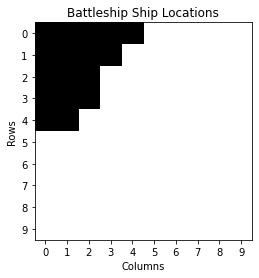

In [3]:
'''
..........
...A...DD.
...A......
...A......
...A......
...A....C.
........C.
.S......C.
.S........
.S..BBBB..
'''
board = '''
AAAAA.....
BBBB......
CCC.......
SSS.......
DD........
..........
..........
..........
..........
..........
'''
boardHeatMap = np.array([[1 if ch != '.' else 0 for ch in row ] for row in board.lstrip('\n').rstrip('\n').split('\n')], dtype=int)
r, c = boardHeatMap.shape
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.xticks(ticks=np.arange(c), labels=np.arange(c))
plt.yticks(ticks=np.arange(r), labels=np.arange(r))
plt.title('Battleship Ship Locations')
im = plt.imshow(boardHeatMap, cmap='binary', interpolation='nearest')
#ax = plt.gca()
#plt.colorbar(im)
#plt.grid(color='gray', linestyle='-.', linewidth=1)
plt.savefig('shiplocation.png')

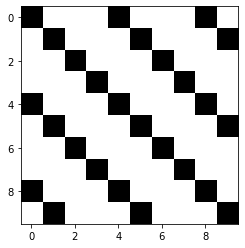

In [4]:
a = np.zeros((10, 10))
for i, value in np.ndenumerate(a):
    if i[0] % 4 == i[1] % 4:
        a[i] = 1
plt.imshow(a, cmap='binary', interpolation='nearest')

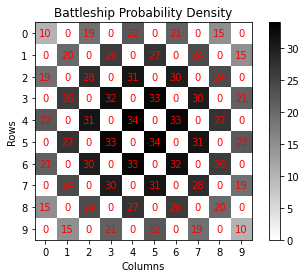

(4, 4)
Missed!


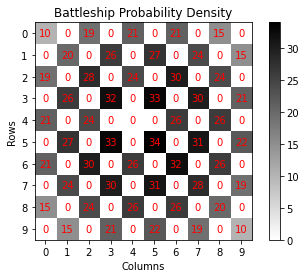

(5, 5)
Missed!


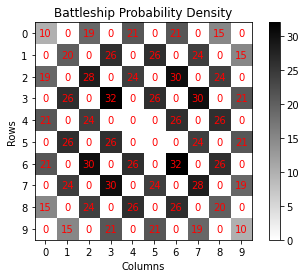

(3, 3)
Missed!


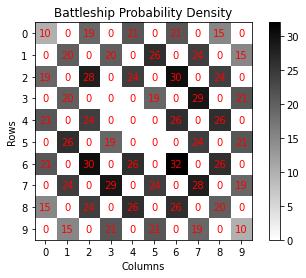

(6, 6)
Missed!


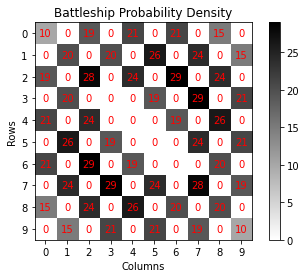

(2, 6)
Missed!


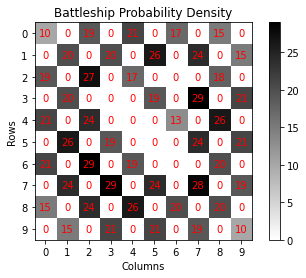

(3, 7)
Missed!


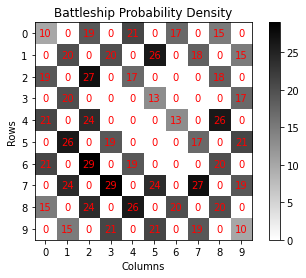

(6, 2)
Missed!


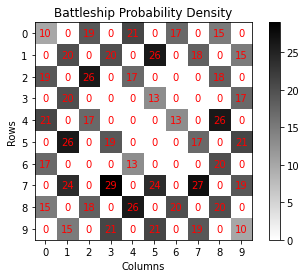

(7, 3)
Missed!


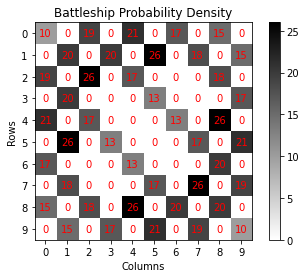

(1, 5)
Missed!


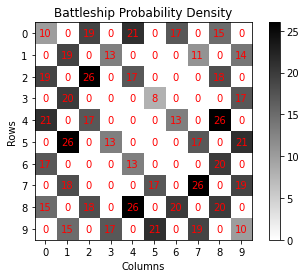

(2, 2)
Hit!


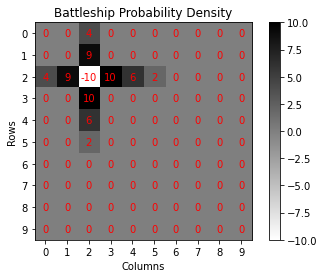

(2, 3)
Missed!


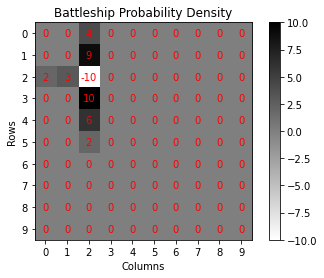

(3, 2)
Hit!


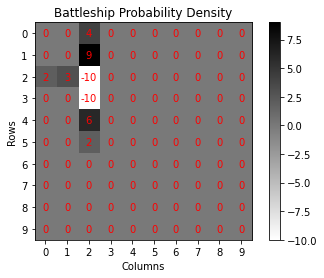

(1, 2)
Hit!


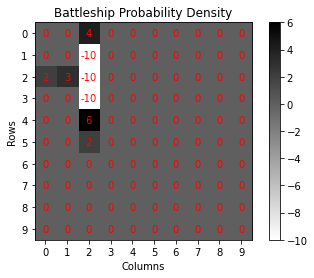

(4, 2)
Missed!


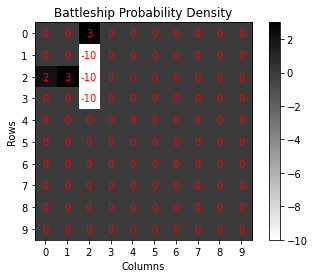

(0, 2)
Hit!


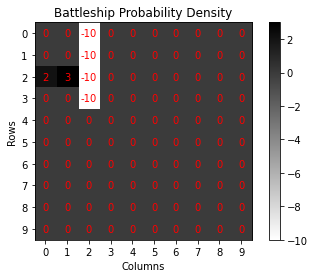

(2, 1)
Hit!


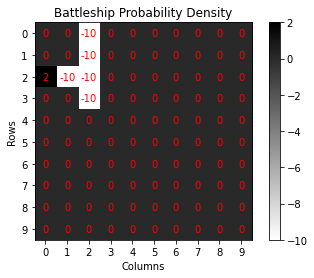

(2, 0)
Hit!
cruiser destroyed!
3


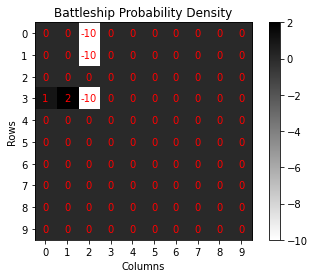

(3, 1)
Hit!


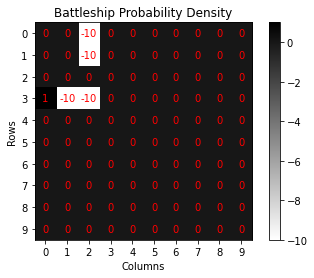

(3, 0)
Hit!
submarine destroyed!
2


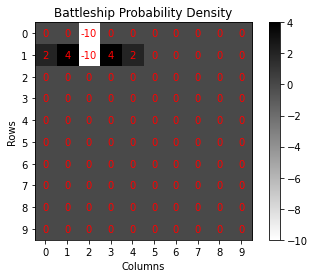

(1, 1)
Hit!


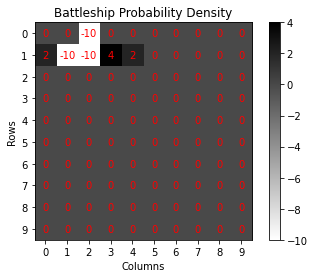

(1, 3)
Hit!


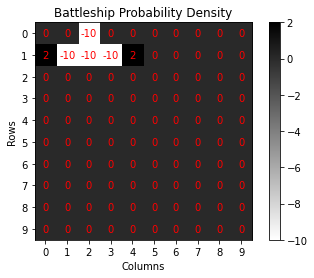

(1, 0)
Hit!
battleship destroyed!
1


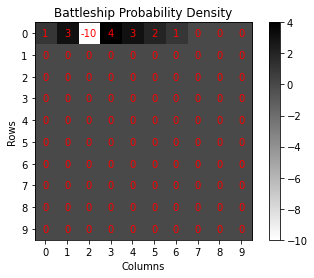

(0, 3)
Hit!


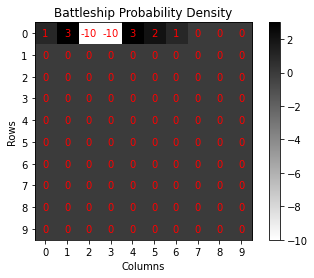

(0, 1)
Hit!


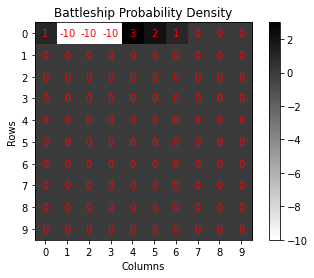

(0, 4)
Hit!


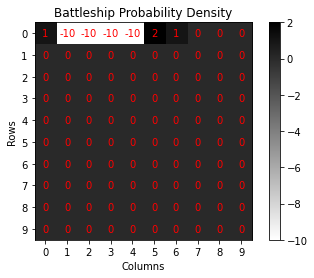

(0, 5)
Missed!


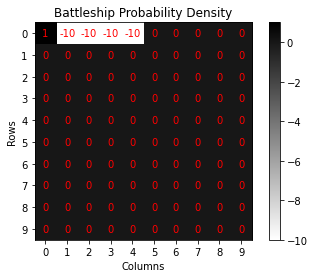

(0, 0)
Hit!
aircraft carrier destroyed!
0


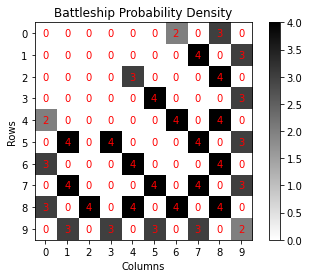

(1, 7)
Missed!


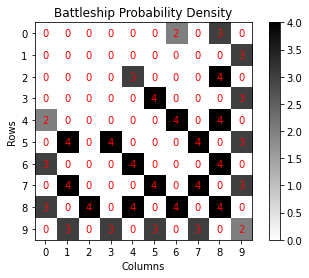

(2, 8)
Missed!


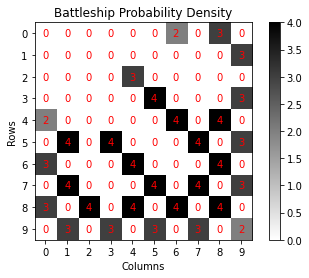

(3, 5)
Missed!


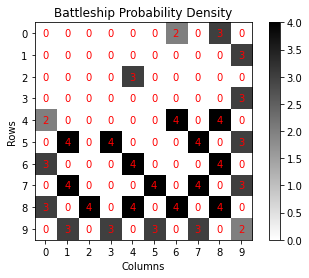

(4, 6)
Missed!


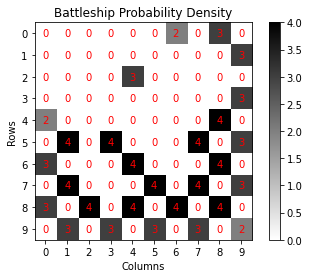

(4, 8)
Missed!


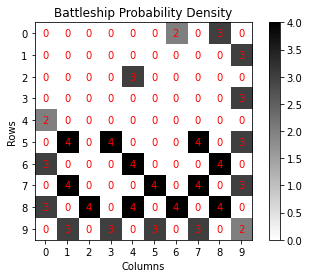

(5, 1)
Missed!


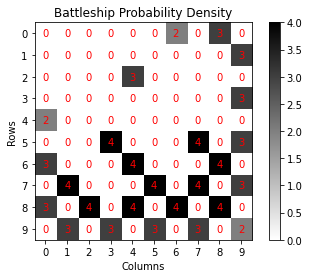

(5, 3)
Missed!


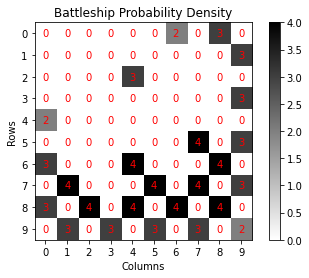

(5, 7)
Missed!


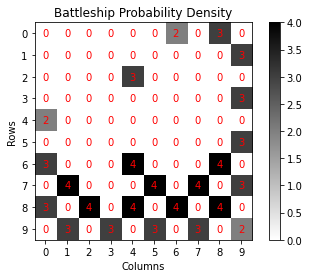

(6, 4)
Missed!


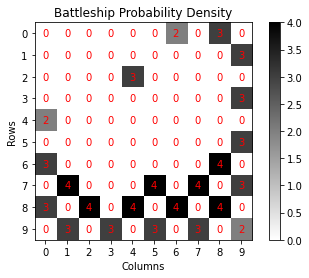

(6, 8)
Missed!


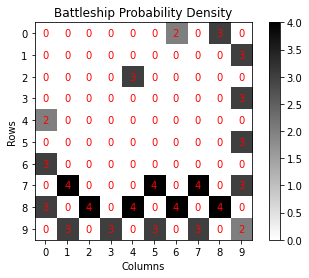

(7, 1)
Missed!


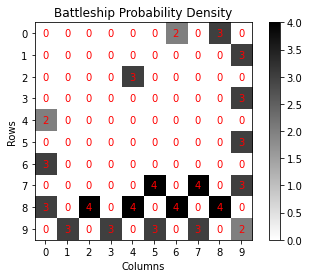

(7, 5)
Missed!


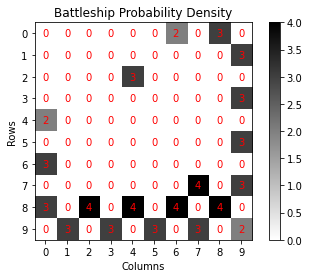

(7, 7)
Missed!


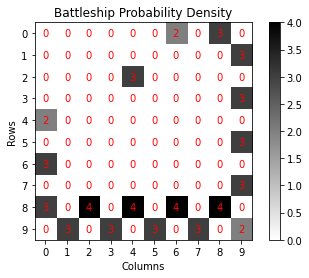

(8, 2)
Missed!


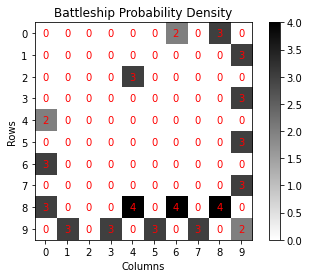

(8, 4)
Missed!


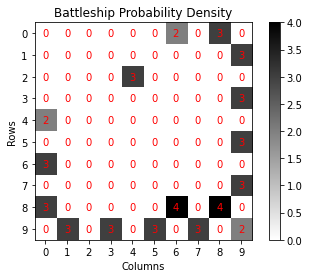

(8, 6)
Missed!


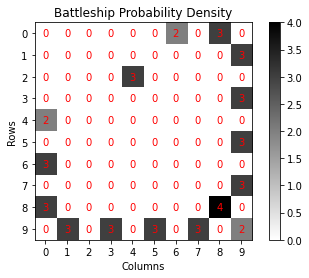

(8, 8)
Missed!


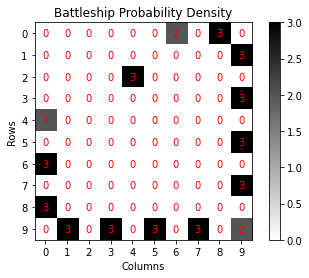

(0, 8)
Missed!


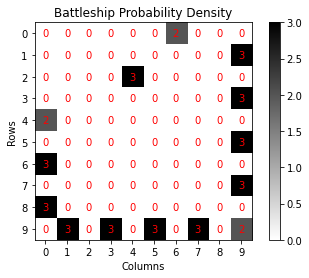

(1, 9)
Missed!


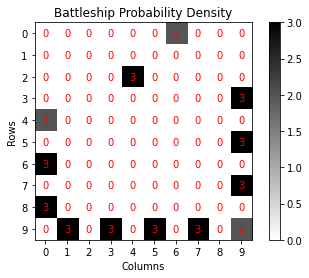

(2, 4)
Missed!


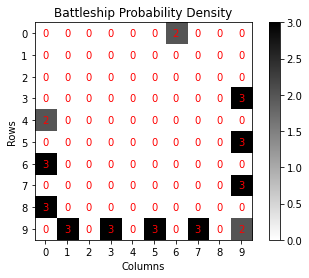

(3, 9)
Missed!


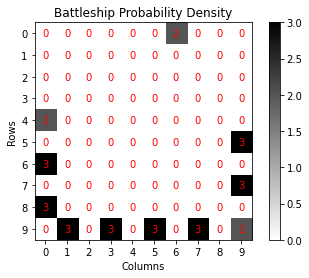

(5, 9)
Missed!


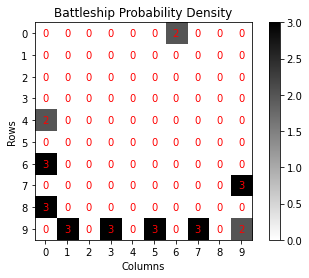

(6, 0)
Missed!


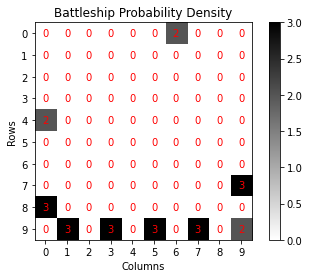

(7, 9)
Missed!


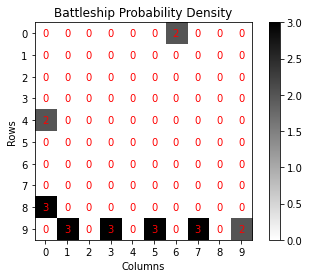

(8, 0)
Missed!


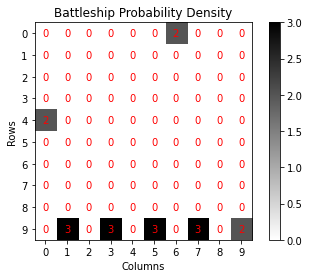

(9, 1)
Missed!


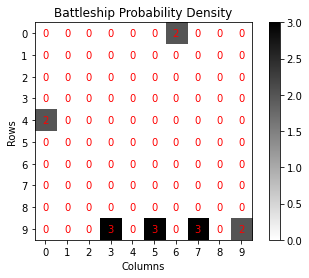

(9, 3)
Missed!


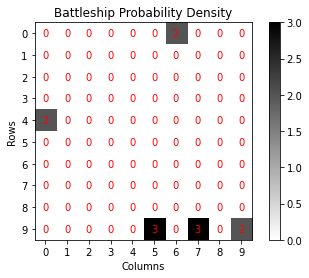

(9, 5)
Missed!


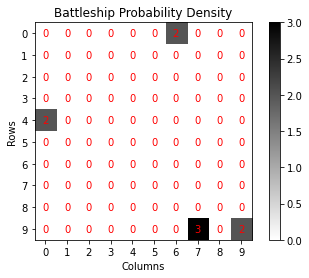

(9, 7)
Missed!


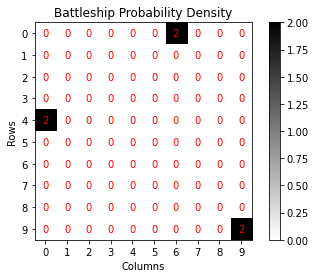

(0, 6)
Missed!


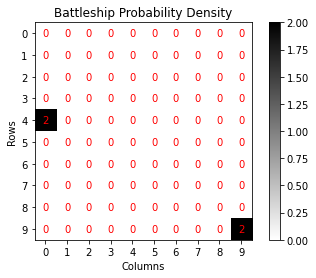

(4, 0)
Hit!


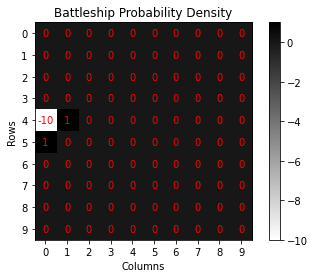

(4, 1)
Hit!
destroyer destroyed!
0


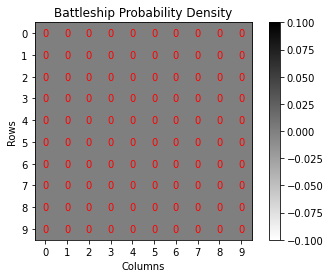

Finished in 59 moves!


In [6]:
board = '''
AAAAA.....
BBBB......
CCC.......
SSS.......
DD........
..........
..........
..........
..........
..........
'''
ship_types = [Ship(3, 'C', 'cruiser'), Ship(2, 'D', 'destroyer'), Ship(3, 'S', 'submarine'), Ship(4, 'B', 'battleship'), Ship(5, 'A', 'aircraft carrier')]
game = np.array([[ch for ch in row] for row in board.lstrip('\n').rstrip('\n').split('\n')])
p = GoodPlayer(game, ship_types)

o = 0
while (p.attack()):
    o += 0